In [ ]:
# Hindi Spam Detection

# Importing the Libraries

In [ ]:
import pandas as pd
import re 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from lazypredict.Supervised import LazyClassifier

from sklearn.metrics import accuracy_score
from sklearn.preprocessing  import StandardScaler
from imblearn.over_sampling import RandomOverSampler

print("Importing Done")


ModuleNotFoundError: No module named 'lazypredict'

In [ ]:
# Load dataset with appropriate encoding

df = pd.read_csv('Spam_or_ham.csv', encoding='utf-8')


print("Dataset Overview:")
print("-" * 10)
print(f"Total messages: {len(df)}")


Dataset Overview:
----------
Total messages: 2000


In [ ]:
df

,Message,Category
0,"""बधाई हो! हमने सीरीज़ B फ़ंडिंग में $29 मिलियन...",spam
1,"अंतिम मौका! संचार मास्टरक्लास पर 70% की छूट, स...",spam
2,फिटनेस पर 60% छूट! अपनी प्रीमियम मेंबरशिप अपग्...,spam
3,"Alibaba.com पर थोक में खरीदें। फैशन, प्लेड ड्र...",spam
4,अपने आप को सरकारी एजेंसीयों/रिज़र्व बैंक (RBI)...,ham
...,...,...
1995,आपके Mobile नंबर में समस्या है। सुधार करें: ht...,spam
1996,बिना शुल्क ₹5 लाख तक का लोन। अभी आवेदन करें: h...,spam
1997,आपका मोबाइल रिचार्ज पेंडिंग है। अभी चेक करें: ...,spam
1998,आपके PAN कार्ड को अपडेट करें। सुधार करें: http...,spam


In [ ]:


# Define regex patterns and spam keywords
patterns = {
    'url': r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
    'phone': r'\b[\+]?[0-9][0-9\-]{9,}\b',
    'money': r'(?:₹|RS|INR|\$)\s*\d+(?:,\d+)*(?:\.\d{2})?',
    'special_chars': r'[!@#$%^&*(),.?":{}|<>]'
}

spam_words = [
    'फ्री', 'मुफ्त',  
    'जल्दी', 'लिमिटेड',  
    'विजेता', 'इनाम', 
    'ऑफर', 'कॉल', 
    'क्लिक', 'लकी',
    'खरीदें', 'बधाई',
    'मौका', 'शीघ्र'
]
print("\nregex patterns")



regex patterns


In [ ]:
#Feature Extraction Functions

def extract_basic_features(message):
    return {
        'message_length': len(message),
        'word_count': len(message.split())
    }

def extract_pattern_features(message, patterns):
    return {
        'has_url': int(bool(re.search(patterns['url'], message))),
        'has_phone': int(bool(re.search(patterns['phone'], message))),
        'has_money': int(bool(re.search(patterns['money'], message))),
        'special_char_count': len(re.findall(patterns['special_chars'], message))
    }

def count_spam_words(message, spam_words):
    return sum(word in message for word in spam_words)


print("Defining Functions")


Defining Functions


In [ ]:
# Initialize and fit TF-IDF
vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = vectorizer.fit_transform(df['Message'])
tfidf_scores = tfidf_matrix.mean(axis=1).A1

In [ ]:
# Convert 'Category' to binary and add as the last column
df['is_spam'] = (df['Category'].str.lower() == 'spam').astype(int)

# Extract all features for each message
features_list = []
for idx, message in enumerate(df['Message']):
    # Combine all features
    features = {}
    features.update(extract_basic_features(message))
    features.update(extract_pattern_features(message, patterns))
    features['spam_word_count'] = count_spam_words(message, spam_words)
    features['tfidf_score'] = tfidf_scores[idx]
    features_list.append(features)

# Create features dataframe
features_df = pd.DataFrame(features_list)

# Combine features with original data
# Place the 'is_spam' column as the last column
result_df = pd.concat([
    df[['Message']],  # Keep original message
    features_df,      # Add features in between
    df[['is_spam']]   # Add binary category column at the end
], axis=1)

# Display the final dataframe
print(result_df.head())


                                             Message  message_length  \
0  "बधाई हो! हमने सीरीज़ B फ़ंडिंग में $29 मिलियन...             207   
1  अंतिम मौका! संचार मास्टरक्लास पर 70% की छूट, स...             178   
2  फिटनेस पर 60% छूट! अपनी प्रीमियम मेंबरशिप अपग्...             178   
3  Alibaba.com पर थोक में खरीदें। फैशन, प्लेड ड्र...             180   
4  अपने आप को सरकारी एजेंसीयों/रिज़र्व बैंक (RBI)...             200   

   word_count  has_url  has_phone  has_money  special_char_count  \
0          38        0          0          1                   5   
1          32        0          0          1                   7   
2          27        0          0          0                   4   
3          32        0          0          0                   4   
4          34        0          0          0                   4   

   spam_word_count  tfidf_score  is_spam  
0                2         0.03        1  
1                2         0.02        1  
2                0         0.

In [ ]:
features_df

,message_length,word_count,has_url,has_phone,has_money,special_char_count,spam_word_count,tfidf_score
0,207,38,0,0,1,5,2,0.03
1,178,32,0,0,1,7,2,0.02
2,178,27,0,0,0,4,0,0.03
3,180,32,0,0,0,4,1,0.04
4,200,34,0,0,0,4,1,0.03
...,...,...,...,...,...,...,...,...
1995,84,10,1,0,0,3,0,0.02
1996,84,12,1,0,1,3,0,0.02
1997,96,10,1,0,0,3,0,0.02
1998,89,10,1,0,0,3,0,0.02


In [ ]:
print("Feature:")
print("-" * 50)
print(features_df.describe())
features_df


Feature:
--------------------------------------------------
       message_length  word_count  has_url  has_phone  has_money  \
count         2000.00     2000.00  2000.00    2000.00    2000.00   
mean           106.10       19.76     0.14       0.08       0.08   
std            107.90       19.31     0.35       0.27       0.27   
min              9.00        2.00     0.00       0.00       0.00   
25%             47.00        9.00     0.00       0.00       0.00   
50%             77.00       14.00     0.00       0.00       0.00   
75%            136.25       24.25     0.00       0.00       0.00   
max           1707.00      338.00     1.00       1.00       1.00   

       special_char_count  spam_word_count  tfidf_score  
count             2000.00          2000.00      2000.00  
mean                 2.52             0.43         0.02  
std                  3.31             0.81         0.01  
min                  0.00             0.00         0.00  
25%                  1.00            

,message_length,word_count,has_url,has_phone,has_money,special_char_count,spam_word_count,tfidf_score
0,207,38,0,0,1,5,2,0.03
1,178,32,0,0,1,7,2,0.02
2,178,27,0,0,0,4,0,0.03
3,180,32,0,0,0,4,1,0.04
4,200,34,0,0,0,4,1,0.03
...,...,...,...,...,...,...,...,...
1995,84,10,1,0,0,3,0,0.02
1996,84,12,1,0,1,3,0,0.02
1997,96,10,1,0,0,3,0,0.02
1998,89,10,1,0,0,3,0,0.02


In [ ]:
# Save to Excel
result_df.to_excel('spam_features.xlsx', index=False)

print("Final Dataset Sample:")
print("-" * 50)
df=result_df
print(df.head())

print("\nSpam Distribution:")
print(df['is_spam'].value_counts())

Final Dataset Sample:
--------------------------------------------------
                                             Message  message_length  \
0  "बधाई हो! हमने सीरीज़ B फ़ंडिंग में $29 मिलियन...             207   
1  अंतिम मौका! संचार मास्टरक्लास पर 70% की छूट, स...             178   
2  फिटनेस पर 60% छूट! अपनी प्रीमियम मेंबरशिप अपग्...             178   
3  Alibaba.com पर थोक में खरीदें। फैशन, प्लेड ड्र...             180   
4  अपने आप को सरकारी एजेंसीयों/रिज़र्व बैंक (RBI)...             200   

   word_count  has_url  has_phone  has_money  special_char_count  \
0          38        0          0          1                   5   
1          32        0          0          1                   7   
2          27        0          0          0                   4   
3          32        0          0          0                   4   
4          34        0          0          0                   4   

   spam_word_count  tfidf_score  is_spam  
0                2         0.03        1  

In [ ]:

def extract_features(df):
    features = pd.concat(
        [
            df[['message_length','word_count','has_url','has_phone','has_money','special_char_count','spam_word_count','tfidf_score']]
        ],
        axis=1
    )
    return features

features=extract_features(df)


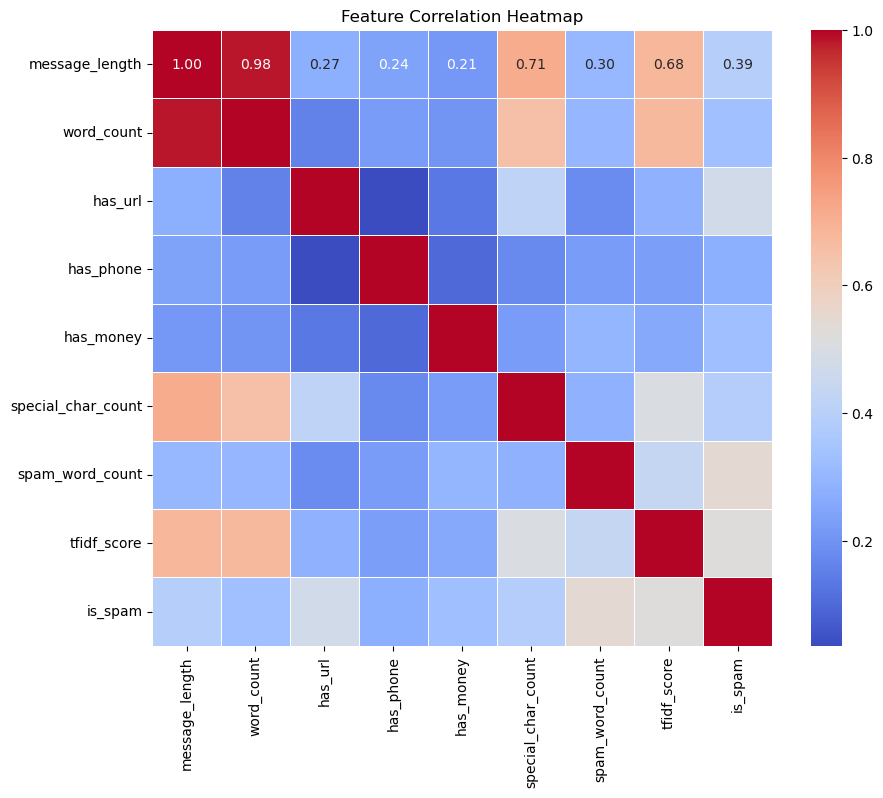

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Calculate correlation matrix
correlation_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
X=features
y=df['is_spam']

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=100)
X_test

,message_length,word_count,has_url,has_phone,has_money,special_char_count,spam_word_count,tfidf_score
1025,70,16,0,0,0,3,0,0.01
1208,41,10,0,0,0,0,0,0.00
1055,23,6,0,0,0,1,0,0.01
367,165,28,1,0,0,5,0,0.03
815,34,8,0,0,0,0,0,0.01
...,...,...,...,...,...,...,...,...
807,49,9,0,0,0,0,0,0.00
711,39,6,0,0,0,0,0,0.02
1541,198,41,0,0,0,3,0,0.03
1001,49,10,0,0,0,0,0,0.02


In [ ]:
# Scale and Oversample Dataset
def scale_dataset(X, y, oversample=False):
    # Scale features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Oversample if needed
    if oversample:
        ros = RandomOverSampler(random_state=42)
        X, y = ros.fit_resample(X, y)

    return X, y


In [ ]:
# Scale and oversample training data
X_train_scaled, y_train_scaled = scale_dataset(X_train, y_train, oversample=True)

# Scale only test data (y_test doesn't need scaling or oversampling)
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)


In [ ]:
print("Spam messages (is_spam=1):", len(y_train_scaled[y_train_scaled == 1]))
print("Ham messages (is_spam=0):", len(y_train_scaled[y_train_scaled == 0]))

Spam messages (is_spam=1): 996
Ham messages (is_spam=0): 996


In [ ]:
print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Sample of X_train_scaled:")
print(X_train_scaled[:5])  # Display the first 5 rows


Shape of X_train_scaled: (1992, 8)
Sample of X_train_scaled:
[[-0.58707721 -0.45006498 -0.40660963 -0.29237251 -0.28217394 -0.4605148
  -0.53405558 -0.51826636]
 [ 0.13976352  0.11084308 -0.40660963 -0.29237251 -0.28217394 -0.75979331
  -0.53405558  0.31673453]
 [ 0.17610556  0.11084308 -0.40660963 -0.29237251 -0.28217394 -0.4605148
  -0.53405558 -0.01049513]
 [-0.75970188 -0.75601483 -0.40660963 -0.29237251 -0.28217394 -0.75979331
  -0.53405558 -1.36677061]
 [-0.5779917  -0.50105662 -0.40660963 -0.29237251 -0.28217394 -0.4605148
  -0.53405558 -2.57239265]]


In [ ]:
model = RandomForestClassifier(random_state = 45)
model.fit(X_train_scaled,y_train_scaled)


RandomForestClassifier(random_state=45)

In [ ]:
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 91.75%


In [ ]:
# Step 1: Initialize the Logistic Regression model
logistic_model = LogisticRegression()

logistic_model.fit(X_train, y_train)

y_pred = logistic_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the Logistic Regression model:",accuracy)

Accuracy of the Logistic Regression model: 0.8925


In [ ]:

tfidf = TfidfVectorizer()  
X_tfidf = tfidf.fit_transform(df['Message'])
X_train, X_test, y_train, y_test = train_test_split(X_tfidf.toarray(),y,test_size=0.2,random_state=43) # type: ignore

In [ ]:
# Initialize LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Display results
print(models)


 97%|███████████████████████████████████████████████████████████████████████████████▏  | 28/29 [01:05<00:01,  1.86s/it]

[LightGBM] [Info] Number of positive: 631, number of negative: 969
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4040
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 166
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.394375 -> initscore=-0.428959
[LightGBM] [Info] Start training from score -0.428959


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [01:06<00:00,  2.30s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
ExtraTreesClassifier               0.96               0.95     0.95      0.96   
XGBClassifier                      0.92               0.91     0.91      0.92   
RandomForestClassifier             0.92               0.91     0.91      0.92   
LGBMClassifier                     0.91               0.90     0.90      0.91   
NearestCentroid                    0.92               0.89     0.89      0.92   
Perceptron                         0.90               0.89     0.89      0.90   
AdaBoostClassifier                 0.91               0.89     0.89      0.90   
BaggingClassifier                  0.90               0.89     0.89      0.90   
DecisionTreeClassifier             0.89               0.87     0.87      0.88   
PassiveAggressiveClassifier        0.88               0.86     0.86      0.88   
SGDClassifier               

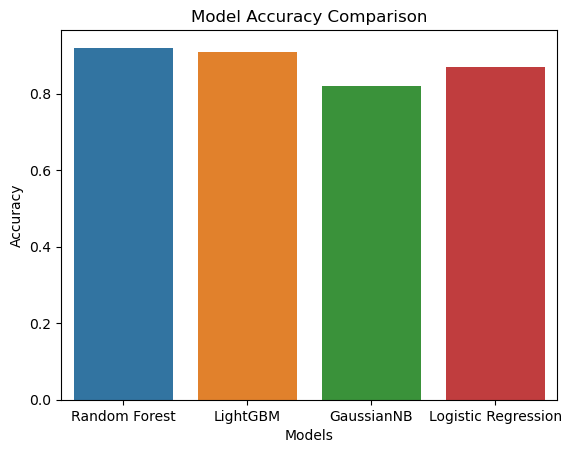

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Model performance visualization
models = ['Random Forest', 'LightGBM', 'GaussianNB', 'Logistic Regression']
accuracies = [0.92, 0.91, 0.82, 0.87]

sns.barplot(x=models, y=accuracies)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Models")
plt.show()